In [0]:
import zipfile
import os

In [0]:
train_path = '/content/drive/My Drive/Train.tar.zip'
with zipfile.ZipFile(train_path, 'r') as zip:
    zip.extractall()

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()


import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

In [0]:
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        
        self.data_info = pd.read_csv("/content/testset.csv")
        self.data_info = self.data_info.sort_values(by = ['Data'])
        self.data_info = self.data_info.reset_index()
        self.file_names = [file for _,_,files in os.walk(self.file_path) for file in files]
        self.file_names = sorted(self.file_names)

        self.len = len(self.file_names)
        
        
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self,  index):
        file_name = self.file_names[index]
        image_data = self.pil_loader(self.file_path +"/" + file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            Y1 = self.get_classes(index)
            label = Y1
            return image_data, label
    
    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            image_data = img.convert('RGB')
            return image_data
    
    def get_classes(self, index):
        classs = self.data_info['Label'][index]
        return classs
    

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [0]:
transform = transforms.Compose([
                            transforms.RandomResizedCrop(448),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
                           # mean and std in 3 channels with mean and std of 0.5 an 0.5
])



In [0]:
full_data = VowelConsonantDataset("/content/testset",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)

In [0]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)


torch.Size([64, 3, 448, 448]) torch.Size([64])


In [0]:
y

tensor([22, 20, 14, 18, 36, 17, 32, 11, 22,  8, 45, 30, 15, 26, 41, 18, 29,  3,
        39, 39, 34,  9, 37, 13,  3, 36, 13, 16, 33, 42,  1,  0,  6, 13,  1, 15,
        42,  2,  2, 44, 28, 13, 24, 27, 28, 38,  7, 35,  2, 33, 34, 17, 21, 43,
        31,  6, 44, 26, 28,  9,  2, 46, 42, 19])

In [0]:
images, labels = next(iter(train_loader))
labels

tensor([33,  5, 36, 30,  7, 33,  1, 19, 30, 45, 26,  2, 34, 28, 28, 34, 38, 46,
         6,  8, 18, 31, 23, 17, 17, 19, 11,  5, 32,  3, 22,  3, 43, 29, 22,  1,
        19, 18, 43, 19, 42,  8, 24, 12,  8, 12, 32, 42, 38, 14, 30, 37,  6, 36,
        34,  6, 33, 23, 22, 30,  4, 19, 35, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


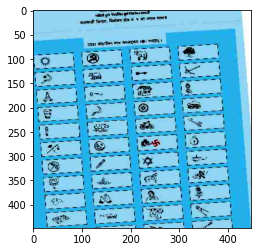

In [0]:
import numpy as np
def imshow(img, label):
    label = label.squeeze()
    title = f'V_{np.argmax(label[0])}C_{np.argmax(label[1])}'
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')
    plt.show
    
    
img = images[3]
npimg = img.numpy()
npimg = np.transpose(npimg, (1,2,0))
plt.imshow(npimg)

In [0]:
images.shape

torch.Size([64, 3, 448, 448])

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        # 224*224
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  
        # 112*112
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) 
        # 56 *56
        #torch.Size([3136, 1024])
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 500)
        self.fc2 = nn.Linear(500, 48)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
 
        x = x.view(-1, 64 * 56 * 56)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=48, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


'\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        # convolutional layer (sees 32x32x3 image tensor)\n        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # (N, 3, 32, 32) -> (N,16, 32, 32) ___ w =  [ w- f+ 2p / (s) ]+ 1\n        # convolutional layer (sees 16x16x16 tensor)\n        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # (N, 16, 32, 32) -> (N, 32 ,32 ,32)\n        # convolutional layer (sees 8x8x32 tensor)\n        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # (N, 32 ,32 ,32) -> ( N,64, 32 ,32 ) \n        #torch.Size([64, 64, 28, 28])\n        # torch.Size([3136, 1024])\n        # max pooling layer\n        self.pool = nn.MaxPool2d(2, 2)\n        # linear layer (64 * 4 * 4 -> 500)\n        self.fc1 = nn.Linear(64 * 4 * 4, 500)\n        # linear layer (500 -> 10)\n        self.fc2 = nn.Linear(500, 48)\n        # dropout layer (p=0.25)\n        self.dropout = nn.Dropout(0.25)\n

In [0]:
model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=48, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

In [0]:
n_epochs = 10

valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
  
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
  
    model.eval()
    for data, target in validation_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4.071567 	Validation Loss: 3.873184
Validation loss decreased (inf --> 3.873184).  Saving model ...
Epoch: 2 	Training Loss: 3.871667 	Validation Loss: 3.873643
Epoch: 3 	Training Loss: 3.871511 	Validation Loss: 3.874005
Epoch: 4 	Training Loss: 3.871454 	Validation Loss: 3.874202
Epoch: 5 	Training Loss: 3.871450 	Validation Loss: 3.874598
Epoch: 6 	Training Loss: 3.871452 	Validation Loss: 3.874877
Epoch: 7 	Training Loss: 3.871456 	Validation Loss: 3.875241
Epoch: 8 	Training Loss: 3.871360 	Validation Loss: 3.875366
Epoch: 9 	Training Loss: 3.871363 	Validation Loss: 3.875581
Epoch: 10 	Training Loss: 3.871684 	Validation Loss: 3.875528
